# Model performance figure

In [27]:
import sys
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("../src")
import bayesprev

In [28]:
# plot params
#sns.set(font_scale=2)
#sns.set_style('ticks')
ymin = -.1
ymax = .9
chance_level = 0.
emotions = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise']

## Preprocess results

In [29]:
df_emo = pd.read_csv('../results/validation/target-emotion_scores.tsv', sep='\t', index_col=0)
df_emo = df_emo.sort_values(['feature_set', 'emotion'], axis=0)
df_emo['type'] = ['combined' if '+' in row['feature_set'] else
                  'dynamic' if 'dynamic' in row['feature_set'] else 'static'
                   for _, row in df_emo.iterrows()]

dfs = []
for target in ['valence', 'arousal']:
    df = pd.read_csv(f'../results/validation/target-{target}_scores.tsv', sep='\t', index_col=0)
    df['target'] = target
    dfs.append(df)

df_circ = pd.concat(dfs, axis=0)
df_circ = df_circ.sort_values('feature_set', axis=0)
df_circ['type'] = ['combined' if '+' in row['feature_set'] else
                   'dynamic' if 'dynamic' in row['feature_set'] else 'static'
                    for _, row in df_circ.iterrows()]

## P-values
Not because I want to, but because I have to.

IndexError: index 2 is out of bounds for axis 1 with size 2

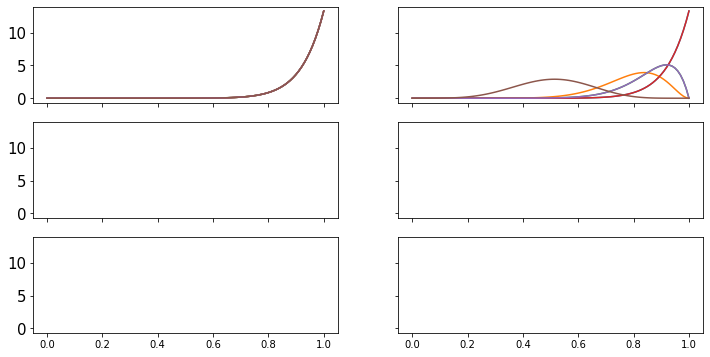

In [30]:
from scipy.stats import ttest_1samp
np.set_printoptions(suppress=True)

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(12, 6), sharex=True, sharey=True)

for i, tpe in enumerate(df_emo['type'].unique()):
    df = df_emo.query("type == @tpe")
    for emo in df['emotion'].unique():
        scores = df.query("emotion == @emo").loc[:, 'score'].to_numpy()
        k = (scores > 0).sum()
        n = scores.size
        x = np.linspace(0,1,100)
        alpha = 0.05
        
        posterior = bayesprev.posterior(x,k,n,alpha)
        
        ax = axes[0, i]
        ax.plot(x,posterior)

        #t, p = ttest_1samp(scores, popmean=0)
        #print(f"P-value for type = {tpe} and emotion = {emo}: {p}")


for i, target in enumerate(['valence', 'arousal']):
    for ii, tpe in enumerate(df_circ['type'].unique()):
        df = df_circ.query("target == @target & type == @tpe")
        scores = df['score'].to_numpy()
        k = (scores > 0).sum()
        n = scores.size
        x = np.linspace(0,1,100)
        alpha = 0.05
        
        posterior = bayesprev.posterior(x,k,n,alpha)
        
        ax = axes[ii+1, i]
        ax.plot(x,posterior)

        # add MAP as a point
        xmap = bayesprev.map(k,n,alpha)
        pmap = bayesprev.posterior(xmap,k,n,alpha)
        ax.plot(xmap, pmap,'.', markersize=20)

        # add lower bound as a vertical line
        bound = bayesprev.bound(0.95,k,n,alpha)
        pbound = bayesprev.posterior(bound,k,n,alpha)
        ax.vlines(bound, 0, pbound, linestyles=':') 

        # add 95% HPDI
        oil = 2;
        iil = 4;
        h = bayesprev.hpdi(0.95,k,n,alpha)
        ax.hlines(pmap, h[0], h[1],linewidths=oil)
        # add 50% HPDI
        h = bayesprev.hpdi(0.5,k,n,alpha)
        ax.hlines(pmap, h[0], h[1],linewidths=iil)

        if i == 0:
            ax.set_xlabel('Population prevalence proportion')
ax.set_ylabel('Posterior density')

ax.set_xlim(0, 1.05)
ax.set_ylim(0, 15)
sns.despine()
fig.tight_layout()

Create figure:

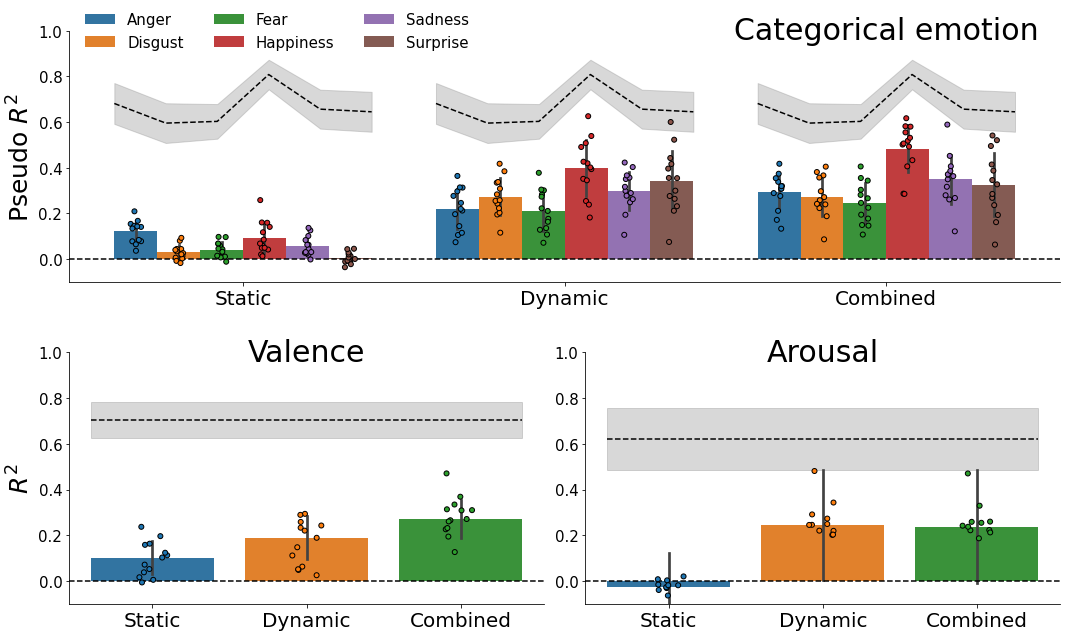

In [32]:
import matplotlib as mpl
mpl.rcParams['ytick.labelsize'] = 15

fig = plt.figure(figsize=(15, 9))
gs = fig.add_gridspec(2, 2)
ax = fig.add_subplot(gs[0, :])
ax = sns.barplot(
    x='type', y='score', hue='emotion', data=df_emo,
    ci='sd', ax=ax, order=['static', 'dynamic', 'combined']
)
handles = ax.get_legend().legendHandles

ax = sns.stripplot(
    x='type', y='score', hue='emotion', data=df_emo,
    order=['static', 'dynamic', 'combined'], ax=ax,
    dodge=True, jitter=True, edgecolor='black', linewidth=1
)
ax.legend(handles, emotions, frameon=False,
          loc=[0.01, 0.9], fontsize=15, ncol=3)
ax.set_xticklabels(['Static', 'Dynamic', 'Combined'], fontsize=20)

# noise ceilings
nc = pd.read_csv('../results/target-emotion_noiseceilings.tsv', sep='\t')
nc['type'] = ['combined' if '+' in row['feature_space'] else
              'dynamic' if 'dynamic' in row['feature_space'] else 'static'
               for _, row in nc.iterrows()]
nc_av = nc.groupby('type').mean().drop('sub', axis=1)
nc_std = nc.groupby('type').std().drop('sub', axis=1)

for xt, idx in zip(ax.get_xticks(), ['dynamic', 'dynamic', 'combined']):
    this_nc_av = nc_av.loc[idx, :].to_numpy()
    this_nc_std = nc_std.loc[idx, :].to_numpy()
    xs = np.linspace(xt - 0.4, xt + 0.4, 6)
    ax.plot(xs, this_nc_av, ls='--', c='k')
    plt.fill_between(xs,
                     this_nc_av + this_nc_std,
                     this_nc_av - this_nc_std,
                     color='gray', alpha=0.3)
ax.set_ylim(-0.1, 1)
ax.axhline(chance_level, ls='--', c='k')
ax.set_xlabel('')
ax.text(2, 1, 'Categorical emotion', va='center', ha='center', fontsize=30)
ax.set_ylabel(r'Pseudo $R^2$', fontsize=25)

# VALENCE/AROUSAL
nc = pd.read_csv('../results/target-valencearousal_noiseceilings.tsv', sep='\t')
nc['type'] = ['combined' if '+' in row['feature_space'] else
              'dynamic' if 'dynamic' in row['feature_space'] else 'static'
               for _, row in nc.iterrows()]
nc_av = nc.groupby('type').mean().drop('sub', axis=1)
nc_std = nc.groupby('type').std().drop('sub', axis=1)
for i, t in enumerate(['valence', 'arousal']):
    ax = fig.add_subplot(gs[1, i])
    dat = df_circ.query("target == @t")
    ax = sns.barplot(order=['static', 'dynamic', 'combined'],
                     data=dat, x='type', y='score', ci='sd', ax=ax, estimator=np.median)
    ax = sns.stripplot(order=['static', 'dynamic', 'combined'],
                       data=dat, x='type', y='score', ax=ax,
                       dodge=True, jitter=True, edgecolor='black', linewidth=1)
    
    ax.set_xlabel('')
    ax.set_ylim(-0.1, 1)
    ax.axhline(chance_level, ls='--', c='k')
    
    if i == 1:
        ax.set_ylabel('')
    else:
        ax.set_ylabel(r"$R^2$", fontsize=25)

    ax.text(1, 1, t.capitalize(), fontsize=30, va='center', ha='center')

    #for xt, idx in zip(ax.get_xticks(), ['dynamic', 'dynamic', 'combined']):
    this_nc_av = nc_av.loc[idx, t]
    this_nc_std = nc_std.loc[idx, t]
    xs = [-0.4, 2.4]
    #xs = [xt - 0.4, xt + 0.4]
    ax.plot(xs, [this_nc_av, this_nc_av], ls='--', c='k')
    ax.fill_between(
        xs, this_nc_av + this_nc_std,
        this_nc_av - this_nc_std,
        color='gray', alpha=0.3)

    ax.set_xticklabels(['Static', 'Dynamic', 'Combined'], fontsize=20)


sns.despine()
fig.tight_layout(h_pad=3)
fig.savefig('../figures/performance_barplot.png', dpi=200)

In [ ]:
preds = {}
preds['emotion'] = pd.read_csv('../results/validation/target-emotion_preds.tsv', sep='\t', index_col=0)
preds['valence'] = pd.read_csv('../results/validation/target-valence_preds.tsv', sep='\t', index_col=0)
preds['arousal'] = pd.read_csv('../results/validation/target-arousal_preds.tsv', sep='\t', index_col=0)

<ipython-input-26-cf211fbcde94>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, i].set_xticklabels(emotions, fontdict={'horizontalalignment': 'center', 'size': 14, 'rotation': 90})
<ipython-input-26-cf211fbcde94>:12: RuntimeWarning: invalid value encountered in true_divide
  cm = np.nanmean(cms / cms.sum(axis=1, keepdims=True), axis=0)
<ipython-input-26-cf211fbcde94>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, i].set_xticklabels(emotions, fontdict={'horizontalalignment': 'center', 'size': 14, 'rotation': 90})


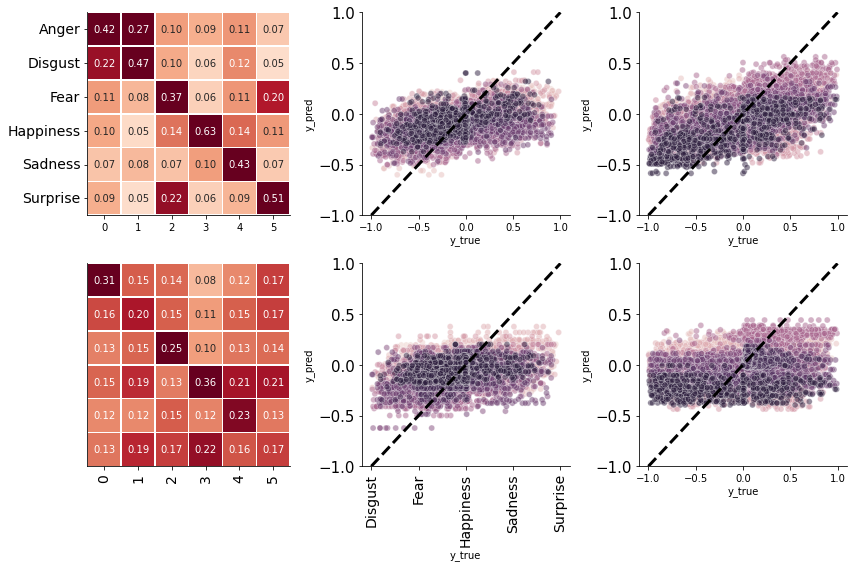

In [26]:
from sklearn.metrics import confusion_matrix
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 8), sharex=False, sharey=False)
for i, tpe in enumerate(['dynamic', 'static']):
    preds_ = preds['emotion'].query(f"feature_set == 'vertexPCA_type-{tpe}'")
    cms = np.zeros((13, 6, 6))
    for ii, sub in enumerate(preds_['sub'].unique()):
        dat = preds_.query("sub == @sub")
        y_pred = dat.iloc[:, :6].to_numpy().argmax(axis=1)
        y_true = dat['y_true'].to_numpy()
        cms[ii, :, :] = confusion_matrix(y_true, y_pred)

    cm = np.nanmean(cms / cms.sum(axis=1, keepdims=True), axis=0)
    axes[i, 0] = sns.heatmap(cm, ax=axes[i, 0], cbar=False, square=True, annot=True, linewidths=.5, cmap='RdBu_r',
                             center=0, vmax=0.25, vmin=0, annot_kws={"size": 10}, fmt='.2f')
    
    axes[i, 0].set_yticklabels(emotions, fontdict={'verticalalignment': 'center', 'size': 14, 'rotation': 0})
    if i == 0:
        axes[i, 0].set_yticklabels(emotions, fontdict={'verticalalignment': 'center', 'size': 14, 'rotation': 0})
    else:
        axes[i, 0].set_yticks([])

    axes[1, i].set_xticklabels(emotions, fontdict={'horizontalalignment': 'center', 'size': 14, 'rotation': 90})

    for ii, target in enumerate(['valence', 'arousal']):
        preds_ = preds[target].query(f"feature_set == 'vertexPCA_type-{tpe}'").copy()
        #preds_.loc[:, 'true-pred'] = preds_['y_true'] - preds_['y_pred']
        sns.scatterplot(x='y_true', y='y_pred', hue='sub', data=preds_, ax=axes[i, ii+1], legend=False, alpha=0.5)
        axes[i, ii+1].set_ylim(-1, 1)
        axes[i, ii+1].set_xlim(-1.1, 1.1)
        axes[i, ii+1].plot(np.linspace(-1, 1), np.linspace(-1, 1), ls='--', c='k', lw=3)
        
        
sns.despine()
fig.tight_layout()